In [1]:
# Import necessary libraries
import pandas as pd
import sys

# Add paths to system path for custom module imports
sys.path.append('../../src/data')
sys.path.append('../../src/features')
sys.path.append('../../src/models')

In [2]:
# Import custom functions from 'make_dataset' module
from make_dataset import load_data, display_head

# Load data
sales_train, sales_test, calendar, sell_prices, calendar_events = load_data()

# Display dataset heads
train_head, test_head, calendar_head, sell_prices_head, calendar_events_head = display_head(sales_train, sales_test, calendar, sell_prices, calendar_events)

In [3]:
from data_preprocessor import DataPreparation
from prophet_forecaster import ProphetForecaster

# Initialize the DataPreparation class with the appropriate arguments
data_preprocessor_instance = DataPreparation(sales_train, calendar, calendar_events, sell_prices)

# Prepare prophet_data and get merged_data
prophet_data, merged_data = data_preprocessor_instance.prepare_prophet_data()

After melting sales_train: (46985090, 8)
After merging with calendar: (46985090, 10)
After merging with sell prices: (46985090, 11)
After merging with aggregated calendar_events: (46985090, 13)


In [ ]:
# Filter rows where 'num_events' is greater than 0
events_data = prophet_data[prophet_data['num_events'] > 0]

# Display the filtered rows
print(events_data)

             ds          y  num_events
8    2011-02-06   83497.56           1
16   2011-02-14   59728.89           1
23   2011-02-21   65547.57           1
39   2011-03-09   58771.82           1
46   2011-03-16   60076.33           1
...         ...        ...         ...
1496 2015-03-05  102463.25           1
1508 2015-03-17   98187.40           1
1527 2015-04-05  133510.81           1
1533 2015-04-11  140711.93           1
1534 2015-04-12  150877.68           1

[126 rows x 3 columns]


In [5]:
# Split data into train and test sets
train_data, test_data, split_idx = data_preprocessor_instance.split_time_series(prophet_data)

# Initialize and train Prophet model on the training data
forecaster = ProphetForecaster()
prophet_model = forecaster.train_model(train_data)

# Assume the number of future events is the average number of past events per day
# This is a simplification; you might need a more sophisticated method to estimate future events
average_num_events = train_data['num_events'].mean()

# Create a future dataframe with 'num_events' values
future_dates = prophet_model.make_future_dataframe(periods=len(test_data))
future_dates['num_events'] = average_num_events  # Assign the estimated number of events to future dates

# Forecast future sales
forecast = forecaster.forecast(prophet_model, days=len(test_data), future_regressors=future_dates['num_events'])

# Evaluate forecasting performance on the test set
forecaster.evaluate_forecast(test_data['y'].values, forecast)

18:33:33 - cmdstanpy - INFO - Chain [1] start processing
18:33:33 - cmdstanpy - INFO - Chain [1] done processing


Splitting at index: 1232
Train data range: 2011-01-29 00:00:00 - 2014-06-13 00:00:00
Test data range: 2014-06-14 00:00:00 - 2015-04-18 00:00:00
MAPE: 779.59%
SMAPE: 7.80%


In [18]:
prophet_data

,ds,y,num_events
0,2011-01-29,81650.61,0
1,2011-01-30,78970.57,0
2,2011-01-31,57706.91,0
3,2011-02-01,60761.20,0
4,2011-02-02,46959.95,0
...,...,...,...
1536,2015-04-14,102896.92,0
1537,2015-04-15,106913.88,0
1538,2015-04-16,98373.49,0
1539,2015-04-17,103030.58,0


In [11]:
prophet_model_final = forecaster.train_model(prophet_data)
forecaster.save_model(prophet_model_final, "../../models/forecasting/final_prophet_model")

prophet_model_final = forecaster.load_model("../../models/forecasting/final_prophet_model")
# Forecast for the next 7 days
future_dates_7 = prophet_model_final.make_future_dataframe(periods=7)
future_dates_7['num_events'] = average_num_events  # Assign the estimated number of events to future dates

# Make the forecast
forecast_7_days = forecaster.forecast(prophet_model_final, days=7, future_regressors=future_dates_7['num_events'])

# Print or plot the forecast for the next 7 days
print(forecast_7_days.tail(7))

18:58:56 - cmdstanpy - INFO - Chain [1] start processing
18:58:56 - cmdstanpy - INFO - Chain [1] done processing


             ds          trend     yhat_lower     yhat_upper    trend_lower  \
1541 2015-04-19  127280.602162  119454.278551  142949.438401  127280.602162   
1542 2015-04-20  127307.209397   96726.817437  119884.193668  127307.209397   
1543 2015-04-21  127333.816633   88974.999788  112429.696067  127333.816633   
1544 2015-04-22  127360.423868   88555.495549  110854.999683  127360.423868   
1545 2015-04-23  127387.031104   88009.338486  111469.276837  127387.031104   
1546 2015-04-24  127413.638339  100315.812480  122224.012346  127413.638339   
1547 2015-04-25  127440.245575  119769.889180  142372.961858  127440.245575   

        trend_upper  additive_terms  additive_terms_lower  \
1541  127280.602162     4636.589834           4636.589834   
1542  127307.209397   -18863.718125         -18863.718125   
1543  127333.816633   -26662.243163         -26662.243163   
1544  127360.423868   -27700.874609         -27700.874609   
1545  127387.031104   -27727.297177         -27727.297177   
1

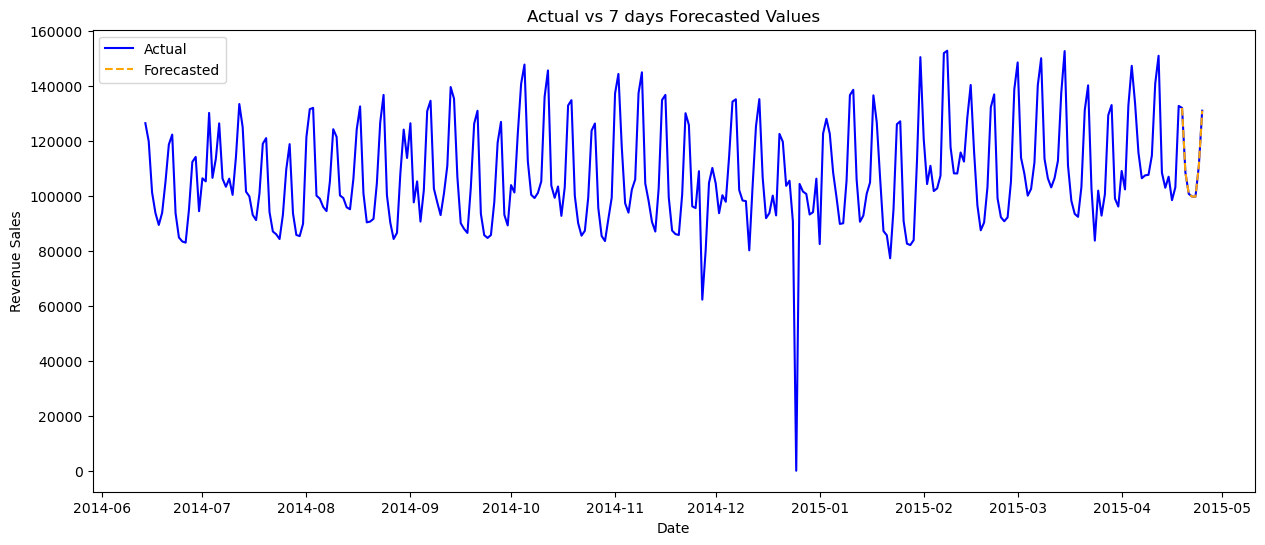

In [17]:
# Extract the last date in the actual data
last_actual_date = test_data['ds'].max()

# Filter forecast_7_days to only include dates after last_actual_date
future_forecast = forecast_7_days[forecast_7_days['ds'] > last_actual_date]

# Concatenate the actual and forecasted data for plotting
plot_data = pd.concat([test_data, future_forecast[['ds', 'yhat']].rename(columns={'yhat': 'y'})])

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(plot_data['ds'], plot_data['y'], label='Actual', color='blue')
plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Forecasted', color='orange', linestyle='dashed')
plt.title('Actual vs 7 days Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Revenue Sales')
plt.legend()
plt.show()

datetime64[ns]


/var/folders/dx/3jf7dwv57sb5kfyzhg7rl93m0000gn/T/ipykernel_36136/3874578091.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['ds'] = pd.to_datetime(test_data['ds'])
/var/folders/dx/3jf7dwv57sb5kfyzhg7rl93m0000gn/T/ipykernel_36136/3874578091.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['ds'] = test_data['ds'].dt.tz_localize(None)


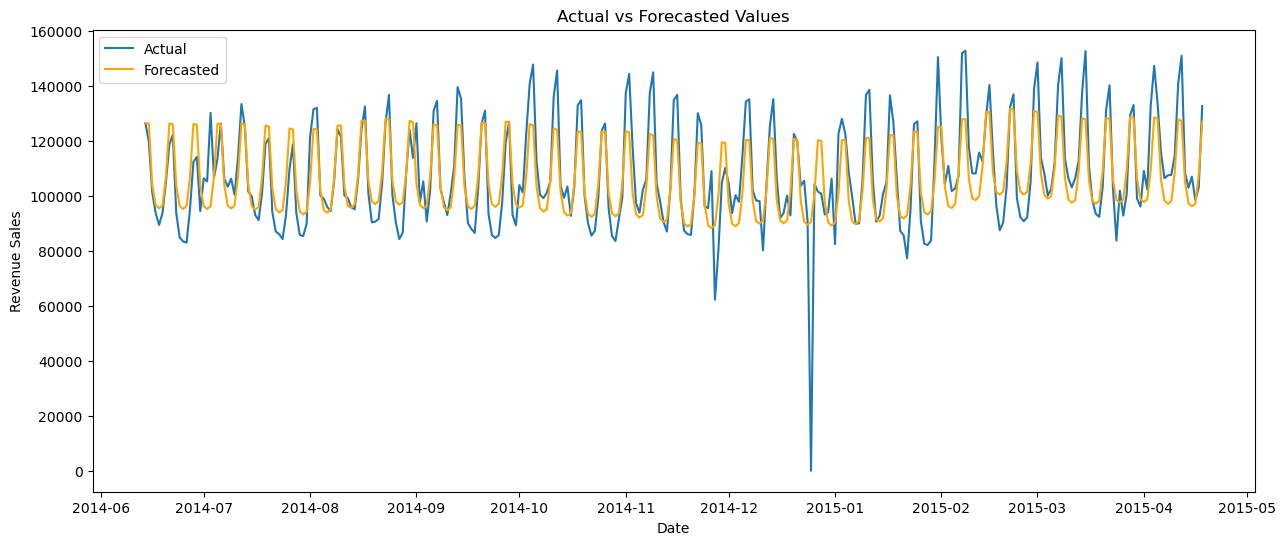

In [13]:
import matplotlib.pyplot as plt
# Ensure 'ds' column is a datetime object
test_data['ds'] = pd.to_datetime(test_data['ds'])

# Check the dtype again
print(test_data['ds'].dtype)

# Subset forecast data to align with test data date range
forecast = forecast[(forecast['ds'] >= test_data['ds'].min()) & (forecast['ds'] <= test_data['ds'].max())]

# Reset index for both DataFrames
forecast.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# Convert timezone-aware to timezone-naive
forecast['ds'] = forecast['ds'].dt.tz_localize(None)
test_data['ds'] = test_data['ds'].dt.tz_localize(None)

# Now try plotting again
plt.figure(figsize=(15, 6))
plt.plot(test_data['ds'], test_data['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted', color='orange')
plt.title('Actual vs Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Revenue Sales')
plt.legend()
plt.show()

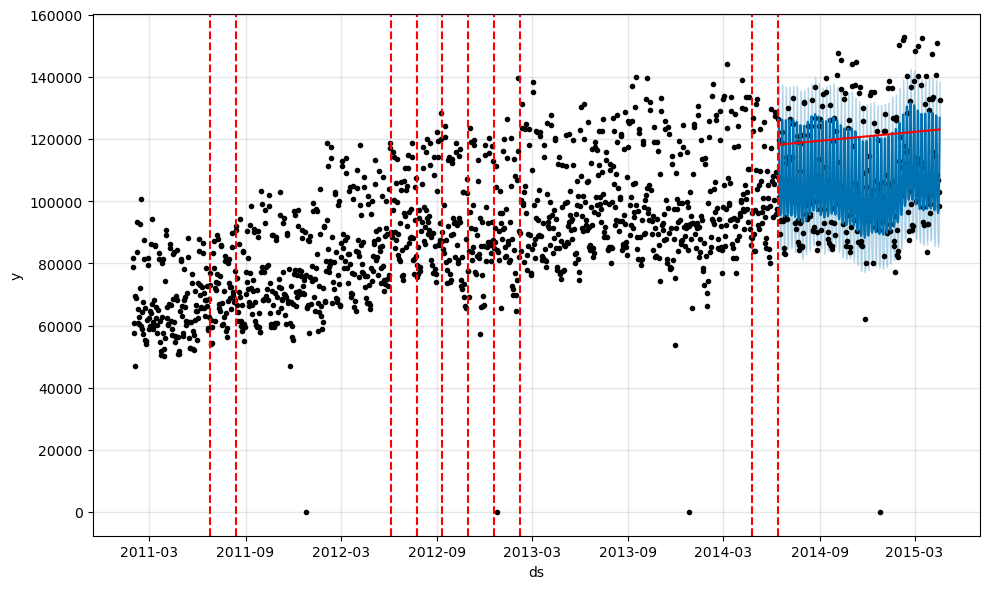

In [15]:
# Plot the forecast
forecaster.plot_forecast(prophet_model_final, forecast, prophet_data)